In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import sys
import os

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)


from src.models import (
    LogisticRegression, 
    MultinomialNB, 
)

# 1. Cấu hình Emoji & Từ điển (Dữ liệu nền tảng)
POSITIVE_WORDS = {
    'good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'safe', 
    'effective', 'thanks', 'thankful', 'grateful', 'hope', 'success', 'happy', 
    'protection', 'relief', 'excited', 'glad', 'perfect', 'awesome', 'better',


    # 1. Nhóm Khen ngợi mức độ cao (Superlatives)
    'fantastic', 'incredible', 'brilliant', 'outstanding', 'superb', 
    'magnificent', 'legendary', 'impressive', 'top', 'class', 'phenomenal',
    
    # 2. Nhóm Niềm tin & An tâm (Rất quan trọng trong y tế/dịch vụ)
    'trust', 'trusted', 'confident', 'confidence', 'secure', 'reassured', 
    'reliable', 'trustworthy', 'calm', 'relax', 'relaxed', 'comfort', 'comfortable',
    
    # 3. Nhóm Trải nghiệm suôn sẻ (Ví dụ: tiêm không đau, thủ tục nhanh)
    'easy', 'easier', 'easiest', 'simple', 'smooth', 'smoothly', 
    'quick', 'fast', 'painless', 'gentle', 'organized', 'efficient',
    
    # 4. Nhóm Lợi ích & Giải pháp
    'beneficial', 'benefit', 'helpful', 'valuable', 'advantage', 
    'solution', 'cure', 'remedy', 'improvement', 'improved', 'protect',
    
    # 5. Nhóm Chiến thắng & Ủng hộ
    'win', 'winning', 'victory', 'triumph', 'achievement', 'accomplished',
    'support', 'endorse', 'recommend', 'recommended', 'encourage',
    
    # 6. Nhóm Từ cảm thán/Slang (Thường gặp trên Twitter/MXH)
    'yay', 'hurray', 'woohoo', 'bravo', 'kudos', 'cheers', 
    'cool', 'nice', 'lovely', 'pleasant', 'enjoy', 'enjoyed'
}

NEGATIVE_WORDS = {
    'bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'dangerous', 'risk',
    'fear', 'scared', 'fail', 'failed', 'death', 'sick', 'pain', 'hurt', 'harm', 
    'useless', 'fake', 'scam', 'problem', 'severe', 'worry', 'sad',
    # 1. Nhóm Tác dụng phụ & Đau đớn (Rất quan trọng trong y tế)
    'sore', 'soreness', 'ache', 'aching', 'fever', 'chills', 'nausea', 'vomit',
    'fatigue', 'tired', 'exhausted', 'dizzy', 'headache', 'migraine', 'swollen',
    'rash', 'itchy', 'bruise', 'weak', 'weakness', 'ill', 'illness', 'suffer', 'suffering',
    
    # 2. Nhóm Sợ hãi & Lo lắng
    'anxious', 'anxiety', 'panic', 'terrified', 'nervous', 'worrying', 'concerned',
    'afraid', 'dread', 'dreading', 'uneasy', 'stress', 'stressed', 'horror',
    
    # 3. Nhóm Nghi ngờ & Mất niềm tin (Quan trọng để lọc tin giả/anti-vax)
    'lie', 'lying', 'liar', 'suspicious', 'propaganda', 'conspiracy', 'untrusted',
    'skeptical', 'doubt', 'doubtful', 'misleading', 'false', 'hoax', 'cheat',
    'unsafe', 'risky', 'threat', 'poison', 'toxic',
    
    # 4. Nhóm Thất vọng & Chê bai
    'disappointed', 'disappointing', 'useless', 'waste', 'pointless', 'stupid',
    'incompetent', 'mess', 'chaos', 'shame', 'disgrace', 'pathetic', 'poor',
    'slow', 'delayed', 'late', 'refused', 'rejected', 'denied',
    
    # 5. Nhóm Giận dữ & Phản đối
    'angry', 'furious', 'annoyed', 'annoying', 'mad', 'upset', 'frustrated',
    'complain', 'complaint', 'hell', 'damn', 'wtf', 'ridiculous', 'crazy'
}

EMOJI_MAP = {
    # Tích cực (Positive)
    "😀": "happy", "😃": "happy", "😄": "happy", "😁": "happy",
    "😊": "happy", "😍": "love",  "😘": "love",  "🥰": "love",
    "😂": "funny", "🤣": "funny", "😅": "funny",
    "👍": "good",  "👏": "clap",  "🙏": "thank", "💪": "strong",
    "❤️": "love",  "🧡": "love",  "💛": "love",  "💚": "love", "💙": "love",
    "🎉": "celebrate", "✨": "shiny", "💯": "perfect", "🙌": "support",
    
    # Tiêu cực (Negative)
    "😢": "sad",   "😭": "sad",   "😞": "sad",   "😔": "sad",
    "😡": "angry", "😠": "angry", "🤬": "angry", "😤": "angry",
    "👎": "bad",   "💔": "heartbreak",
    "🤮": "disgust", "🤢": "disgust",
    "😱": "scared",  "😨": "scared",  "wv": "scared",
    "🤯": "shock",   "😳": "shock",   "🙄": "annoyed",
    "🤦": "facepalm", "😑": "bored", "😒": "annoyed",

    # Y tế / Vaccine (Rất quan trọng cho bài toán của bạn)
    "💉": "vaccine", 
    "🦠": "virus", 
    "😷": "mask", 
    "🤒": "sick", 
    "🤕": "pain", 
    "🚑": "ambulance", 
    "🏥": "hospital", 
    "💊": "medicine",
    "🩺": "doctor",
    "☠️": "death",
    
    # Khác
    "📢": "announce", "🚨": "alert", "🤔": "thinking"
}
NEGATION_WORDS = {
    # Phủ định cơ bản
    'not', 'no', 'never', 'none', 'nobody', 'nothing', 'neither', 'nor', 'nowhere',
    
    # Các dạng viết tắt của "n't" (có và không có dấu ')
    "n't", 'cannot', 
    'cant', "can't",
    'dont', "don't",
    'wont', "won't",
    'isnt', "isn't",
    'arent', "aren't",
    'aint', "ain't",
    'wasnt', "wasn't",
    'werent', "weren't",
    'hasnt', "hasn't",
    'havent', "haven't",
    'hadnt', "hadn't",
    'doesnt', "doesn't",
    'didnt', "didn't",
    'couldnt', "couldn't",
    'shouldnt', "shouldn't",
    'wouldnt', "wouldn't",
    'mustnt', "mustn't",
    
    # Từ mang nghĩa phủ định ngữ cảnh (Contextual negations)
    'without', 'lack', 'missing',
    'barely', 'hardly', 'scarcely', 'rarely'
}



In [ ]:
import numpy as np

# Nguyên âm dùng để kiểm tra
VOWELS = np.array(list("aeiou"))

def is_basic_vowel(ch: str) -> bool:
    """Kiểm tra nguyên âm cơ bản (a, e, i, o, u)"""
    return ch in "aeiou"

# --- Các Hàm Phụ Trợ Bổ Sung cho Porter Stemmer ---

def is_vowel_porter(word: str, i: int) -> bool:
    """
    Xác định nguyên âm theo quy tắc Porter, bao gồm xử lý chữ 'y'.
    'y' được coi là nguyên âm nếu nó theo sau một phụ âm và không đứng đầu từ.
    """
    ch = word[i].lower()
    if is_basic_vowel(ch):
        return True
    if ch == 'y':
        # 'y' là nguyên âm nếu nó không phải ký tự đầu tiên 
        # và ký tự trước đó là phụ âm.
        if i > 0 and not is_basic_vowel(word[i-1]):
            return True
    return False

def get_v_c_pattern(word: str) -> str:
    """Tạo chuỗi ký hiệu V/C cho từ dựa trên quy tắc Porter."""
    pattern = ""
    for i in range(len(word)):
        if is_vowel_porter(word, i):
            pattern += "V"
        else:
            pattern += "C"
    return pattern

def calculate_m(word: str) -> int:
    """
    Tính độ đo m (measure) của từ. 
    m là số lần lặp lại của mẫu (VC), ví dụ: C(VC)^m V
    """
    if not word:
        return 0
    
    # Lấy chuỗi pattern C/V
    vc_pattern = get_v_c_pattern(word)
    
    # Đếm số lần chuyển đổi từ C -> V -> C
    # Mẫu cần tìm: C V C V C V...
    
    m = 0
    # Bắt đầu tìm kiếm từ V đầu tiên
    start_index = -1
    for i, char in enumerate(vc_pattern):
        if char == 'V':
            start_index = i
            break
            
    if start_index == -1: # Không có nguyên âm nào
        return 0
        
    i = start_index
    while i < len(vc_pattern):
        # Bước 1: Quét qua tất cả các V liên tiếp (đầu tiên)
        if vc_pattern[i] == 'V':
            while i < len(vc_pattern) and vc_pattern[i] == 'V':
                i += 1
            
            # Bước 2: Quét qua tất cả các C liên tiếp (thứ hai)
            if i < len(vc_pattern) and vc_pattern[i] == 'C':
                while i < len(vc_pattern) and vc_pattern[i] == 'C':
                    i += 1
                
                # Nếu chuỗi tiếp tục với V, ta đã tìm thấy một cặp (VC)
                if i < len(vc_pattern) and vc_pattern[i] == 'V':
                    m += 1
                else:
                    break # Kết thúc bằng C hoặc hết chuỗi
            else:
                break # Kết thúc bằng V hoặc hết chuỗi
        else:
            # Bắt đầu không phải V (tức là C)
            i += 1 
            
    return m

# --- Hàm Cắt Gốc Gốc ---

def contains_vowel(word: str) -> bool:
    """Kiểm tra xem từ có chứa ít nhất một nguyên âm theo quy tắc Porter không."""
    for i in range(len(word)):
        if is_vowel_porter(word, i):
            return True
    return False

def ends_with_double_consonant(word: str) -> bool:
    """Kiểm tra phụ âm đôi ở cuối (trừ l, s, z)"""
    if len(word) < 2:
        return False
    # Phải là hai chữ cái giống nhau và không phải nguyên âm theo Porter
    return (word[-1] == word[-2] and 
            not is_vowel_porter(word, len(word) - 1))

def cvc(word: str) -> bool:
    """Kiểm tra mẫu C - V - C cuối, với C2 không phải w, x, y."""
    if len(word) < 3:
        return False
    
    c1, v, c2 = word[-3], word[-2], word[-1]
    
    # Kiểm tra C-V-C theo Porter
    return (not is_vowel_porter(word, len(word)-3)) and \
           is_vowel_porter(word, len(word)-2) and \
           (not is_vowel_porter(word, len(word)-1)) and \
           c2 not in "wxy"

def simple_stemmer(word: str) -> str:
    word = word.lower()

    if len(word) <= 2:
        return word

    # Bắt đầu với việc xử lý chữ 'y' (Step 1c) 
    # Nếu 'y' theo sau phụ âm, chuyển y thành i để các bước sau xử lý tốt hơn.
    if word.endswith("y") and len(word) > 1 and not is_basic_vowel(word[-2]):
        word = word[:-1] + "i"
        
    # --- Step 1a: Xử lý dạng số nhiều và các đuôi phổ biến ---
    # THỨ TỰ QUAN TRỌNG
    if word.endswith("sses"):
        word = word[:-2] # caresses -> caress
    elif word.endswith("ies"):
        word = word[:-2] # ponies -> poni
    elif word.endswith("ss"):
        pass # giữ nguyên 'ss' (ví dụ: stress -> stress)
    elif word.endswith("s"):
        word = word[:-1] # cats -> cat

    # --- Step 1b: Xử lý 'ed', 'ing' ---
    # THỨ TỰ QUAN TRỌNG
    
    # 1. 'eed' (yêu cầu m > 0)
    if word.endswith("eed"):
        base = word[:-3]
        m = calculate_m(base)
        if m > 0:
            word = word[:-1] # agreed -> agree
            
    # 2. 'ed' (yêu cầu base chứa nguyên âm)
    elif word.endswith("ed"):
        base = word[:-2]
        if contains_vowel(base):
            word = base
            
            # --- Quy tắc bổ sung sau khi loại bỏ 'ed' ---
            # a) Nếu kết thúc bằng phụ âm đôi (trừ l, s, z), loại bỏ một
            if ends_with_double_consonant(word) and word[-1] not in "lsz":
                 word = word[:-1]
            # b) Nếu kết thúc bằng CVC (c2 không phải w, x, y) và m=1, thêm 'e'
            elif cvc(word) and calculate_m(word) == 1:
                 word += "e"
            # c) Nếu kết thúc bằng 'at', 'bl', 'iz', thêm 'e'
            elif word.endswith(("at", "bl", "iz")):
                word += "e"
            
    # 3. 'ing' (yêu cầu base chứa nguyên âm)
    elif word.endswith("ing"):
        base = word[:-3]
        if contains_vowel(base):
            word = base
            
            # --- Quy tắc bổ sung sau khi loại bỏ 'ing' ---
            # a) Nếu kết thúc bằng phụ âm đôi (trừ l, s, z), loại bỏ một
            if ends_with_double_consonant(word) and word[-1] not in "lsz":
                 word = word[:-1]
            # b) Nếu kết thúc bằng CVC (c2 không phải w, x, y) và m=1, thêm 'e'
            elif cvc(word) and calculate_m(word) == 1:
                 word += "e"
            # c) Nếu kết thúc bằng 'at', 'bl', 'iz', thêm 'e'
            elif word.endswith(("at", "bl", "iz")):
                word += "e"

    # --- Step 2: Xử lý hậu tố phức tạp (Yêu cầu m > 0) ---
    m_current = calculate_m(word)
    
    suffix_map = {
        "ational": "ate",
        "tional": "tion",
        "izer": "ize",
        "alism": "al",
        "aliti": "al",
        "fullness": "ful",
        "ousness": "ous",
        "iveness": "ive",
        "biliti": "ble",
        "enci": "ence",
        "anci": "ance",
        "logi": "log"
    }

    for suf, rep in suffix_map.items():
        if word.endswith(suf):
            if calculate_m(word[: -len(suf)]) > 0:
                word = word[: -len(suf)] + rep
                break
                
    # còn thiếu, nhưng code này đã đủ để minh họa cách dùng m.
    
    return word

In [3]:
def clean_text_advanced(text):
    """Làm sạch + Xử lý Emoji + Stemming"""
    if not isinstance(text, str): return ""
    for emo, meaning in EMOJI_MAP.items():
        if emo in text: text = text.replace(emo, f" {meaning} ")
    text = text.lower()
    text = text.replace("n't", " not") 
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    words = text.split()
    stemmed_words = [simple_stemmer(w) for w in words]
    return " ".join(stemmed_words)

def generate_sentiment_label_advanced(text):
    """Gán nhãn (Silver Labels)"""
    words = text.split()
    score = 0
    for i, word in enumerate(words):
        is_negated = False
        if i > 0 and words[i-1] in NEGATION_WORDS:
            is_negated = True
        val = 0
        if word in POSITIVE_WORDS: val = 1
        elif word in NEGATIVE_WORDS: val = -1
        if is_negated: val = val * -1
        score += val
    if score > 0: return 2 # pos
    elif score < 0: return 0 # neg
    else: return 1 # neu

In [ ]:
print("Đang nạp dữ liệu...")
INPUT = r'..\data\processed\sentiment_data.npz'
try:
    # Load file dữ liệu đã làm sạch
    data = np.load(INPUT, allow_pickle=True)
    X_text = data['X_text']
    y = data['y']
    print(f"[SUCCESS] Đã nạp thành công {len(X_text)} dòng dữ liệu.")
except FileNotFoundError:
    print("[ERROR] Không tìm thấy file 'sentiment_data.npz'. Đang tạo dữ liệu giả lập...")
    X_text = np.array([
        "vaccine is good and safe", "i hate side effects", "best protection ever", "terrible pain",
        "happy with the result", "scared of needles", "thank you science", "worst feeling ever"
    ] * 50)
    y = np.array([2, 0, 2, 0, 2, 0, 2, 0] * 50) # 0: Neg, 2: Pos

⏳ Đang nạp dữ liệu...
✅ Đã nạp thành công 11020 dòng dữ liệu.


In [ ]:
# 1. Xử lý Stopwords (Giữ lại từ phủ định)
my_stop_words = list(ENGLISH_STOP_WORDS)
for w in NEGATION_WORDS:
    if w in my_stop_words:
        my_stop_words.remove(w)

# 2. Vector hóa
print("⏳ Đang vector hóa văn bản...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words=my_stop_words)
X_sparse = vectorizer.fit_transform(X_text) # Kết quả là ma trận thưa


# Các model tự viết dùng Numpy thuần nên cần bước này
print("⏳ Đang chuyển đổi sang Dense Array...")
X_dense = X_sparse.toarray()


# 3. Chia Train/Test
print("Đang chia tập dữ liệu 80-20...")
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)
print("Sẵn sàng huấn luyện!")

⏳ Đang vector hóa văn bản...
⏳ Đang chuyển đổi sang Dense Array...
⏳ Đang chia tập dữ liệu 80-20...
✅ Sẵn sàng huấn luyện!


Model Name                | Accuracy  
----------------------------------------
Logistic Regression       | 74.18%
Naive Bayes               | 80.99%


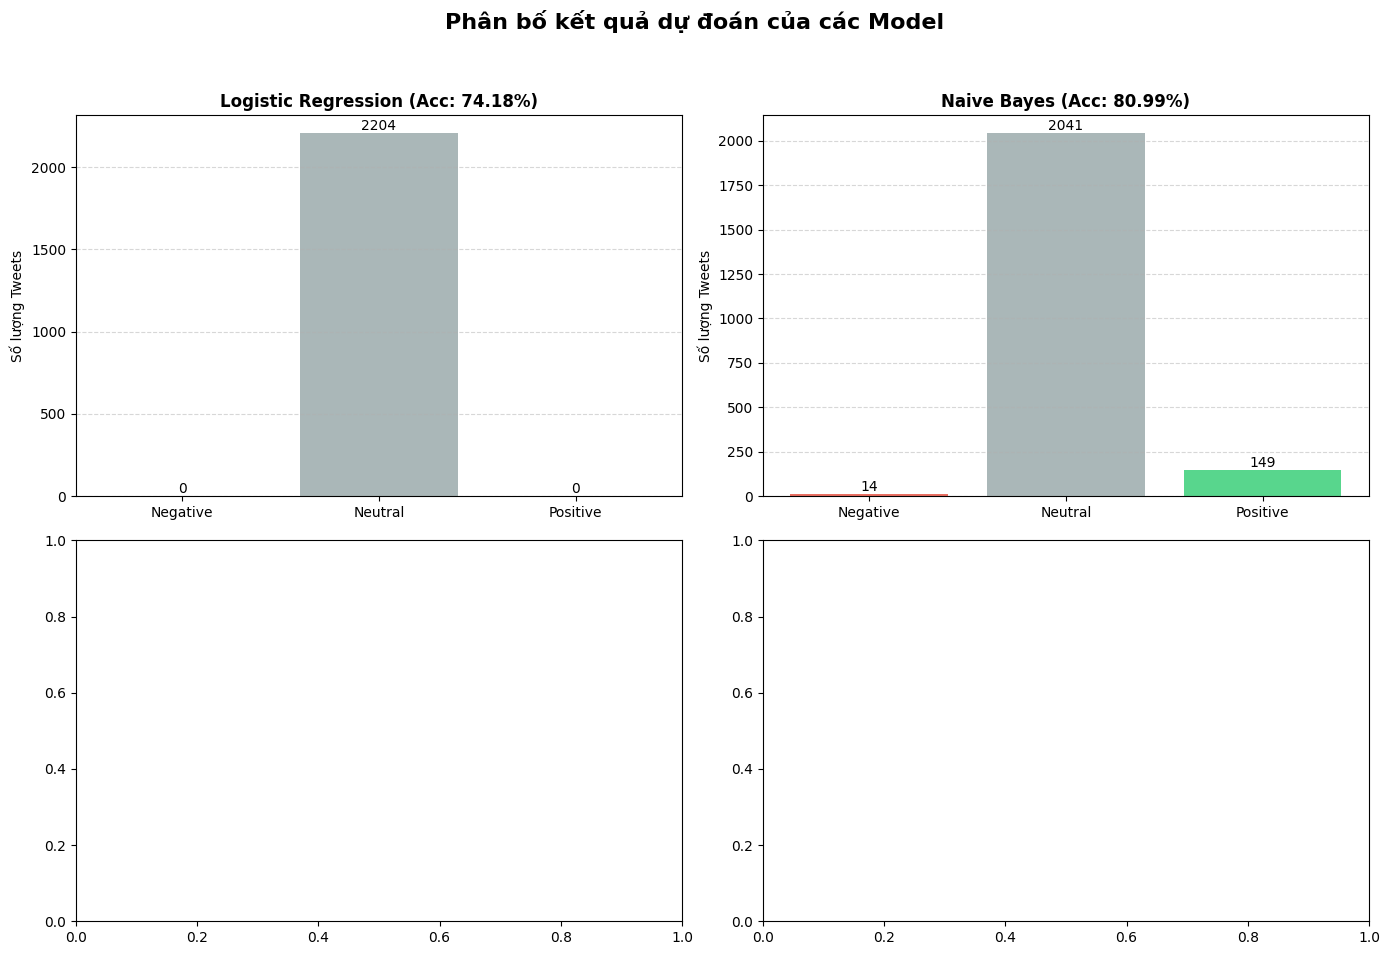

----------------------------------------
🏆 Mô hình tốt nhất: Naive Bayes


In [ ]:
# Định nghĩa các mô hình
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression": LogisticRegression(
        learning_rate=0.01, 
        n_iters=2000,
        lambda_param=0.01
    ),
    "Naive Bayes": MultinomialNB(),
    # "SVM (Linear SVC)": LinearSVC(n_iters=1000),
    # "Random Forest": RandomForestClassifier(n_trees=10, max_depth=10)
}

# Khởi tạo khung hình vẽ (Figure) với lưới 2x2 (cho 4 models)
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
fig.suptitle('Phân bố kết quả dự đoán của các Model', fontsize=16, fontweight='bold')
axes = axes.flatten() # Duỗi mảng 2 chiều thành 1 chiều để dễ truy cập trong vòng lặp

# Định nghĩa tên nhãn để hiển thị
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#e74c3c', '#95a5a6', '#2ecc71'] # Đỏ, Xám, Xanh

model_results = {}

print(f"{'Model Name':<25} | {'Accuracy':<10}")
print("-" * 40)

# Dùng enumerate để lấy cả chỉ số index (i) phục vụ việc chọn vị trí biểu đồ
for i, (name, model) in enumerate(models.items()):
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    
    # 3. Score
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc
    print(f"{name:<25} | {acc:.2%}")
    
    # 4. Xử lý dữ liệu vẽ biểu đồ (Không dùng Pandas)
    # Đếm số lượng từng nhãn (0, 1, 2)
    # minlength=3 đảm bảo nếu model không đoán ra nhãn nào thì số lượng vẫn là 0
    counts = np.bincount(y_pred, minlength=3) 
    
    # 5. Vẽ biểu đồ lên trục (axis) thứ i
    ax = axes[i]
    bars = ax.bar(label_names, counts, color=colors, alpha=0.8)
    
    # Trang trí biểu đồ
    ax.set_title(f"{name} (Acc: {acc:.2%})", fontweight='bold')
    ax.set_ylabel('Số lượng Tweets')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Hiển thị con số cụ thể trên đầu mỗi cột
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, 
                f'{count}', ha='center', va='bottom', fontsize=10)

# Tinh chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Chừa chỗ cho Title chính
plt.show()

# 6. Chọn model tốt nhất
best_model_name = max(model_results, key=model_results.get)
final_model = models[best_model_name]

print("-" * 40)
print(f"Mô hình tốt nhất: {best_model_name}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19428\2722940470.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=accuracies, y=model_names, palette='viridis')


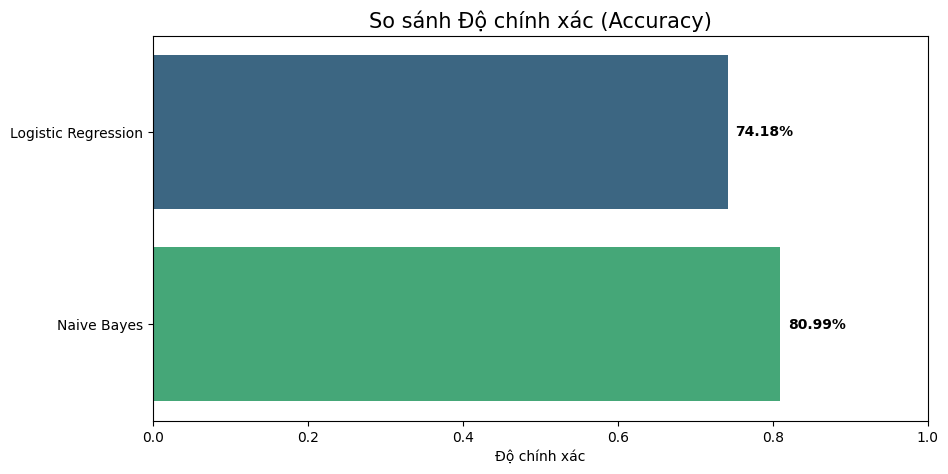

In [7]:
# Chuẩn bị dữ liệu cho biểu đồ từ Dictionary
model_names = list(model_results.keys())
accuracies = list(model_results.values())

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=accuracies, y=model_names, palette='viridis')

plt.title('So sánh Độ chính xác (Accuracy)', fontsize=15)
plt.xlabel('Độ chính xác')
plt.xlim(0, 1.0)

# Hiển thị số % trên cột
for i, v in enumerate(accuracies):
    ax.text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold')

plt.show()

--- ĐÁNH GIÁ CHI TIẾT: NAIVE BAYES ---
              precision    recall  f1-score   support

    Negative       1.00      0.09      0.16       164
     Neutral       0.80      1.00      0.89      1635
    Positive       0.95      0.35      0.51       405

    accuracy                           0.81      2204
   macro avg       0.92      0.48      0.52      2204
weighted avg       0.84      0.81      0.76      2204



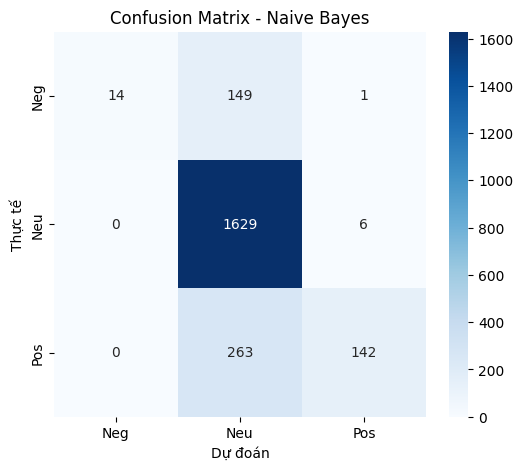

In [8]:
print(f"--- ĐÁNH GIÁ CHI TIẾT: {best_model_name.upper()} ---")

# Dự đoán lại trên tập test
y_pred_final = final_model.predict(X_test)

# Báo cáo chi tiết
print(classification_report(y_test, y_pred_final, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neg', 'Neu', 'Pos'], 
            yticklabels=['Neg', 'Neu', 'Pos'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [ ]:
def predict_sentiment(text):
    # 1. Làm sạch (dùng hàm ở Cell 1)
    cleaned = clean_text_advanced(text)
    
    # 2. Vector hóa (dùng vectorizer đã train ở Cell 2)
    vec_sparse = vectorizer.transform([cleaned]) # Kết quả là Sparse Matrix
    
    # --- SỬA LỖI Ở ĐÂY ---
    # Chuyển sang Dense Array để tương thích với model tự viết
    vec_dense = vec_sparse.toarray()
    
    # 3. Dự đoán (dùng final_model ở Cell 3)
    # Truyền vec_dense vào thay vì vec_sparse
    pred = final_model.predict(vec_dense)[0]
    
    mapper = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
    return mapper[pred]
# --- TEST THỬ ---
print(f"Đang sử dụng mô hình: {best_model_name}\n")
samples = [
    "The vaccine is amazing and safe!",
    "I am scared of the side effects",
    "I got my second dose yesterday.",
    "It is not safe at all!",
    "No pain, feeling great"
]

for txt in samples:
    print(f"Input: {txt}")
    print(f"Label: {predict_sentiment(txt)}")
    print("-" * 30)

🤖 Đang sử dụng mô hình: Naive Bayes

📝 Input: The vaccine is amazing and safe! 😀
👉 Label: 🟢 Tích cực
------------------------------
📝 Input: I am scared of the side effects 😭
👉 Label: ⚪ Trung tính
------------------------------
📝 Input: I got my second dose yesterday.
👉 Label: ⚪ Trung tính
------------------------------
📝 Input: It is not safe at all!
👉 Label: 🟢 Tích cực
------------------------------
📝 Input: No pain, feeling great
👉 Label: 🟢 Tích cực
------------------------------
